# DTM  Classifier

In [5]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load

## Data Analysis Section

<AxesSubplot:title={'center':'Subjects/Nikhil/computed_Hammer.csv'}>

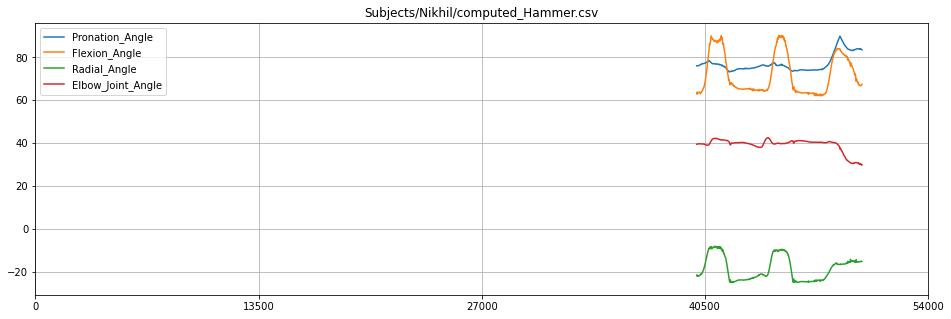

In [8]:
file = 'Subjects/Nikhil/computed_Hammer.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)
df[angle_lables][40000:50000].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

In [8]:
b,a = signal.butter(1, 50,fs=2000)
emg_df = pd.DataFrame(columns=emg_labels)
for labels in emg_labels:
    emg_df[labels] = signal.lfilter(b, a,df[labels])
df[emg_labels] = np.array(emg_df)

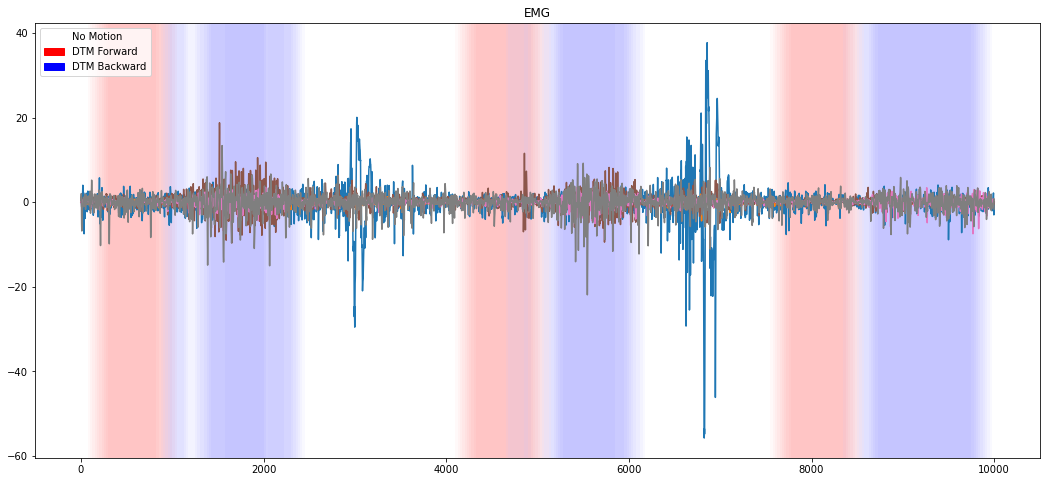

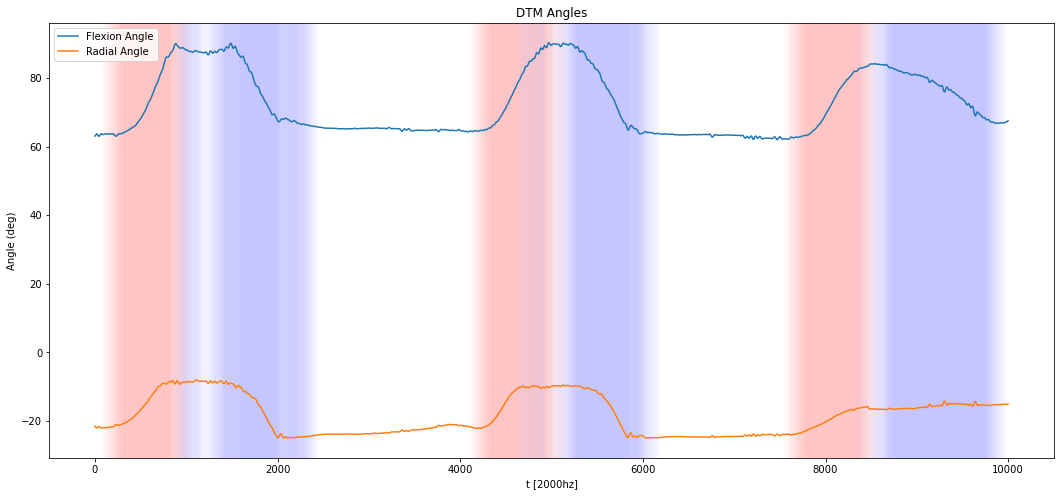

0 -> 42.56410256410256 %
1 -> 23.58974358974359 %
2 -> 33.84615384615385 %


(390, 250, 8)

In [9]:
X, y = prep_data_DTM(df[40000:50000],250,interval=25,Normalize=True,plot=True,angle_thresh=0.005,rms=False)
X.shape

## File Name Generation

In [3]:
files = []
# subjects = ['Fazil','Nikhil','Ingy','Abhishek','Jai', 'Deepti', 'Nirmayee'] #'Fazil/day_04_14_21'
subjects = ['Varun']

In [4]:
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Hammer' ,'Cup'] #, 'Bulb','Screw'
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Varun/computed_Hammer.csv',
 'Subjects/Varun/computed_Hammer01.csv',
 'Subjects/Varun/computed_Hammer02.csv',
 'Subjects/Varun/computed_Cup.csv',
 'Subjects/Varun/computed_Cup01.csv',
 'Subjects/Varun/computed_Cup02.csv']

In [5]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0)[9000:48000])

In [6]:
def filter_df(files_df,order=1,cf=50,fs=2000):
    b,a = signal.butter(1, 50,fs=fs)
    for i in range(len(files_df)):
        emg_df = pd.DataFrame(columns=emg_labels)
        for labels in emg_labels:
            emg_df[labels] = signal.lfilter(b, a,files_df[i][labels])
        files_df[i][emg_labels] = np.array(emg_df)
    return files_df

In [7]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']

In [8]:
files_df = filter_df(files_df)

### Remove Test Reps Data

In [15]:
test_rep_files = ['Subjects/Nikhil/computed_Hammer.csv', 
                  'Subjects/Jai/computed_Hammer.csv', 
                  'Subjects/Deepti/computed_Hammer.csv',
                  'Subjects/Nikhil/computed_Cup.csv', 
                  'Subjects/Jai/computed_Cup.csv', 
                  'Subjects/Deepti/computed_Cup.csv']
tr_range = [40000,50000]

In [92]:
files_df = []
for file in files:
    if file in test_rep_files:
        df = pd.read_csv(file,index_col=0)
        df = df.drop(df.index[tr_range[0]:tr_range[1]])
    else:
        df = pd.read_csv(file,index_col=0)
    files_df.append(df)
files_df = filter_df(files_df)

### Only Removed Reps

In [16]:
files_df = []
files = test_rep_files
for file in files:
    df = pd.read_csv(file,index_col=0)
    files_df.append(df[tr_range[0]:tr_range[1]])
files_df = filter_df(files_df)

<ipython-input-6-8fb7975d4083>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df[i][emg_labels] = np.array(emg_df)
C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## Data Augumentation

### Gausian Noise

In [ ]:
files_df_gausian = []
for df in tqdm(files_df):
    snr = choice(np.linspace(60,90,5))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],snr))
    df[emg_labels] = emg_array
    files_df_gausian.append(df)

files_df = files_df+files_df_gausian
len(files_df)

### Rearrange 

In [51]:
from collections import deque
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [52]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

144

## Data Prep Pipeline

### Parameters

In [17]:
window = 250
interval = 25
Normalize = True
rms = False
angle_thresh_DTM = 0.005

In [18]:
X_dtm, y_dtm = multiple_prep_data_DTM(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh_DTM)
print(X_dtm.shape,y_dtm.shape)


(2340, 250, 8) (2340, 3)


In [ ]:
np.save('X_test_raw',X_dtm)
np.save('y_test_raw',y_dtm)

## Whole Normalize

‘‘time window normalization’’ (i.e., subtracting to
each time window the mean and dividing it by the standard
deviation) and ‘‘normalization based on training data’’ (i.e.,
subtracting to all the time windows the training data mean and
dividing them by the training data standard deviation).

In [ ]:
# X = X_dtm.reshape((X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2]))
# old_range = [X.min(),X.max()]
# new_range = [-1,1]
# scale_param = np.array([old_range,new_range])
# X = map_it(X,old_range,new_range)
# np.save('scale_param',scale_param)
# X = min_max(X)
# X = norm(X)
# X_dtm = X.reshape(X_dtm.shape)

# X = []
# for x in tqdm(X_dtm):
#     X.append(map_it(x,
#                     (x.min(),x.max()),
#                     (-1,1)))
# X_dtm = np.array(X)

In [ ]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [ ]:
X_mean = np.zeros(X_dtm[0].shape)
for x in X_dtm:
    X_mean = X_mean + x
X_mean = X_mean/X_dtm.shape[0]
X_std = np.sqrt(variance(X_dtm))
np.save('mean_std',np.array([X_mean,X_std]))

In [118]:
X_mean = np.load('mean_std_master_norm.npy')[0]
X_std = np.load('mean_std_master_norm.npy')[1]

In [119]:
X = []
for x in tqdm(X_dtm):
    X.append((x-X_mean)/X_std)
X_dtm = np.array(X)

In [ ]:
np.save('prepared_data/X_dtm_rearr_tw',X_dtm)
np.save('prepared_data/y_dtm_rearr_tw',y_dtm)

In [ ]:
X_dtm = np.load('prepared_data/X_dtm_rearr_tw.npy')
y_dtm = np.load('prepared_data/y_dtm_rearr_tw.npy')

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_dtm,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(70320, 250, 8)
(17580, 250, 8)
(70320, 3)
(17580, 3)


In [14]:
del X_dtm
del y_dtm

In [99]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [24]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [101]:
print(count(y_train))
print(count(y_test))

0 - 31424 [ 44.68714448236633 %]
1 - 10815 [ 15.379692832764505 %]
2 - 28081 [ 39.93316268486917 %]
None
0 - 7808 [ 44.41410693970421 %]
1 - 2757 [ 15.68259385665529 %]
2 - 7015 [ 39.9032992036405 %]
None


# InceptionTime Trainer

In [102]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [103]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=3,
                            verbose=True,batch_size=256,nb_epochs=100,nb_filters=32,
                            depth=16, kernel_size=11)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 32)      256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 250, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 250, 32)      10240       conv1d[0][0]                     
______________________________________________________________________________________________

In [104]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/100
275/275 [==============================] - 92s 302ms/step - loss: 0.9582 - accuracy: 0.5038 - val_loss: 0.9315 - val_accuracy: 0.5238


C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
275/275 [==============================] - 81s 296ms/step - loss: 0.8973 - accuracy: 0.5622 - val_loss: 0.8960 - val_accuracy: 0.5750
Epoch 3/100
275/275 [==============================] - 85s 308ms/step - loss: 0.8360 - accuracy: 0.6065 - val_loss: 0.8625 - val_accuracy: 0.6030
Epoch 4/100
275/275 [==============================] - 86s 314ms/step - loss: 0.7693 - accuracy: 0.6534 - val_loss: 0.9678 - val_accuracy: 0.5700
Epoch 5/100
275/275 [==============================] - 87s 318ms/step - loss: 0.6924 - accuracy: 0.7005 - val_loss: 0.7975 - val_accuracy: 0.6523
Epoch 6/100
275/275 [==============================] - 88s 319ms/step - loss: 0.6196 - accuracy: 0.7400 - val_loss: 1.0207 - val_accuracy: 0.6441
Epoch 7/100
275/275 [==============================] - 88s 320ms/step - loss: 0.5559 - accuracy: 0.7732 - val_loss: 0.6955 - val_accuracy: 0.7117
Epoch 8/100
275/275 [==============================] - 87s 317ms/step - loss: 0.4966 - accuracy: 0.8027 - val_loss: 0.6226 -

Epoch 58/100
275/275 [==============================] - 87s 317ms/step - loss: 0.1540 - accuracy: 0.9411 - val_loss: 0.4710 - val_accuracy: 0.8638
Epoch 59/100
275/275 [==============================] - 87s 317ms/step - loss: 0.1544 - accuracy: 0.9399 - val_loss: 0.4454 - val_accuracy: 0.8711
Epoch 60/100
275/275 [==============================] - 87s 315ms/step - loss: 0.1457 - accuracy: 0.9437 - val_loss: 0.5105 - val_accuracy: 0.8548
Epoch 61/100
275/275 [==============================] - 87s 316ms/step - loss: 0.1408 - accuracy: 0.9453 - val_loss: 0.6787 - val_accuracy: 0.8171
Epoch 62/100
275/275 [==============================] - 87s 317ms/step - loss: 0.1426 - accuracy: 0.9451 - val_loss: 0.4559 - val_accuracy: 0.8620
Epoch 63/100
275/275 [==============================] - 87s 316ms/step - loss: 0.1422 - accuracy: 0.9449 - val_loss: 0.5328 - val_accuracy: 0.8427
Epoch 64/100
275/275 [==============================] - 87s 316ms/step - loss: 0.1387 - accuracy: 0.9458 - val_loss: 0

In [105]:
best_model = load_model('best_model.hdf5')
best_model.save('models/DTM_{}_norm_tw.hdf5'.format(window))

C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
system_sleep()

## Testing

In [21]:
model = load_model('models/DTM_250_norm.hdf5')

In [ ]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]

In [ ]:
X_test = []
for x in tqdm(X):
    X_test.append((x-X_mean)/X_std)
X_test = np.array(X_test)

In [22]:
model.evaluate(X_dtm,y_dtm)

74/74 [==============================] - 3s 29ms/step - loss: 3.9491 - accuracy: 0.4487


[3.9490926265716553, 0.44871795177459717]

In [25]:
count(y_dtm)

0 - 906 [ 38.717948717948715 %]
1 - 462 [ 19.743589743589745 %]
2 - 972 [ 41.53846153846154 %]


## Plot Results

In [106]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [107]:
metrics_df

,precision,accuracy,recall,duration
0,0.873924,0.871104,0.852986,8713.634595


<AxesSubplot:title={'center':'Loss'}>

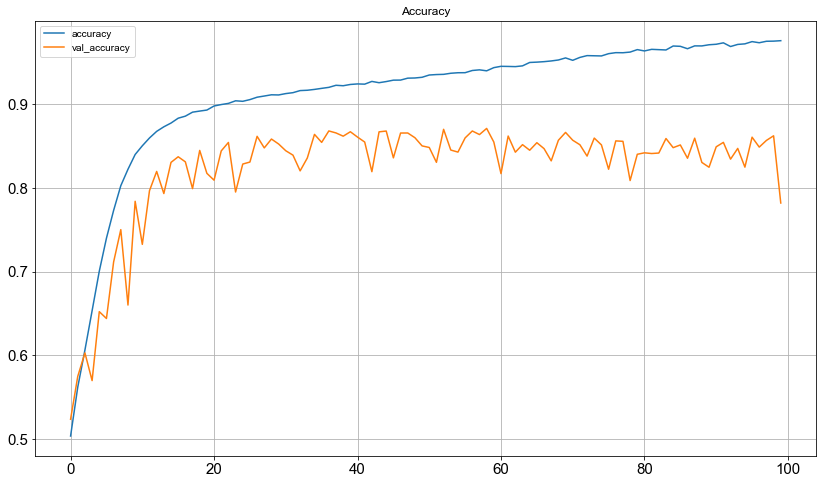

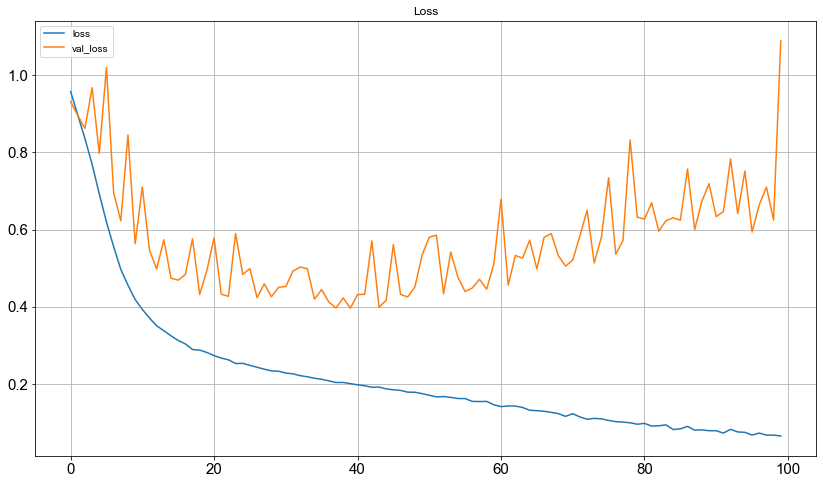

In [108]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

In [ ]:
import os
os.system('shutdown /s /f /t 30')